HW3 ML in business Lukyanov M

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix


import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

#### Создаём датафрейм с таблицей ответов для сравнения

In [7]:
#таблица ответов
compare_classifiers_metrics = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'recall', 'f_score'])
compare_classifiers_metrics

,model,roc_auc,precision,recall,f_score


Добавим классификаторы и запустим кросс-валидацию

In [8]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
model_list = [LogisticRegression, RandomForestClassifier, XGBClassifier]

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def decision (chosen_model):

    
    classifier = Pipeline([
    ('features',feats),
    ('classifier', chosen_model(random_state = 42)),
    ])


    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('For {} CV score is {}+-{}'.format(chosen_model.__name__, round(cv_score, 6), round(cv_score_std, 6)))

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]

    # посчитаем precision/recall/f_score
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    print('For %s Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (chosen_model.__name__,
                                                                            thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    #Нарисуем ROC кривую
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    label_model = ( 'ROC curve ' + chosen_model.__name__ )
    plt.plot(fpr, tpr, lw=lw, label=label_model)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label_model)
    plt.savefig("ROC " + label_model + ".png")
    plt.show()

    
    # Матрица ошибок; мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix ' + chosen_model.__name__)
    plt.savefig("conf_matrix_" + chosen_model.__name__ + ".png")
    plt.show()
    
    return {'model':chosen_model.__name__,
            'roc_auc':roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
            'precision':precision[ix],
            'recall':recall[ix],
            'f_score':fscore[ix]
           } #append row to the dataframe 

For LogisticRegression CV score is 0.78674+-0.008521
For LogisticRegression Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


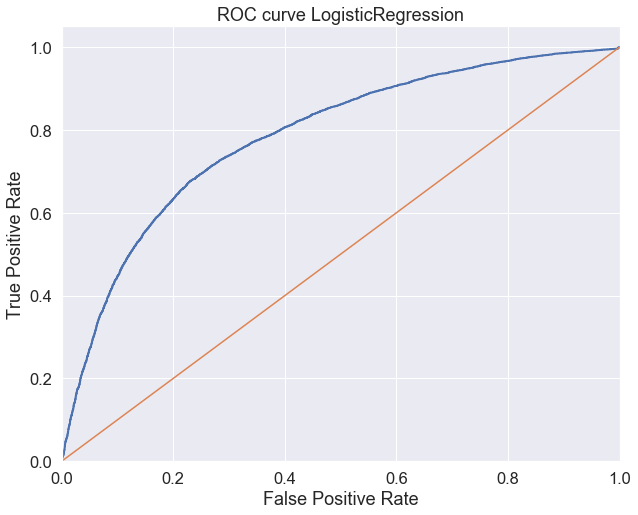

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


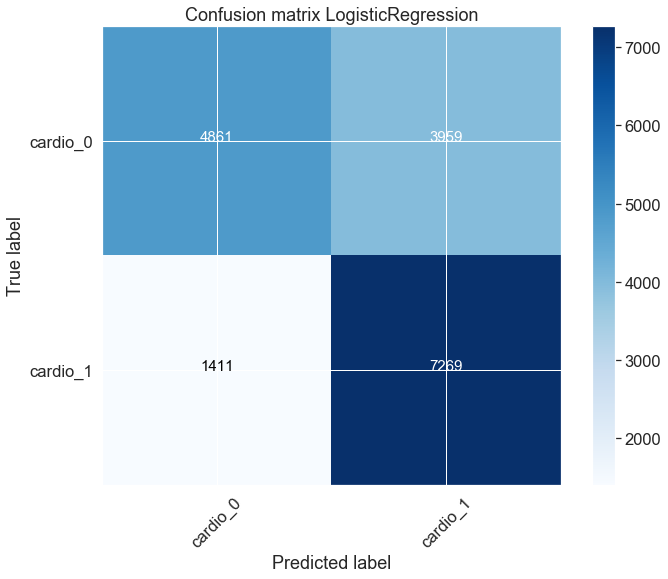

For RandomForestClassifier CV score is 0.77345+-0.007171
For RandomForestClassifier Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


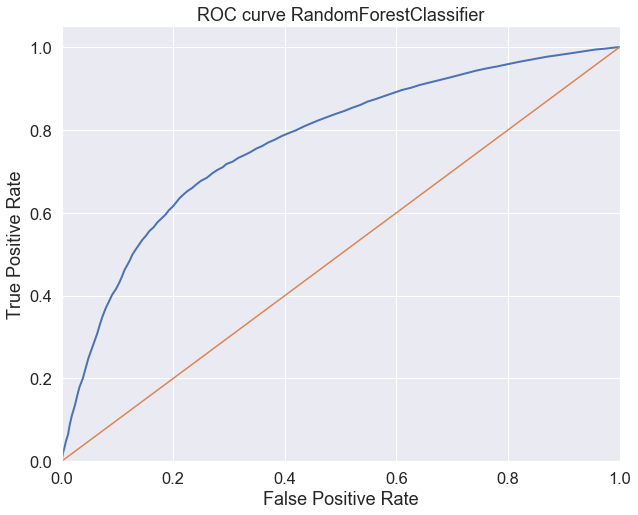

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


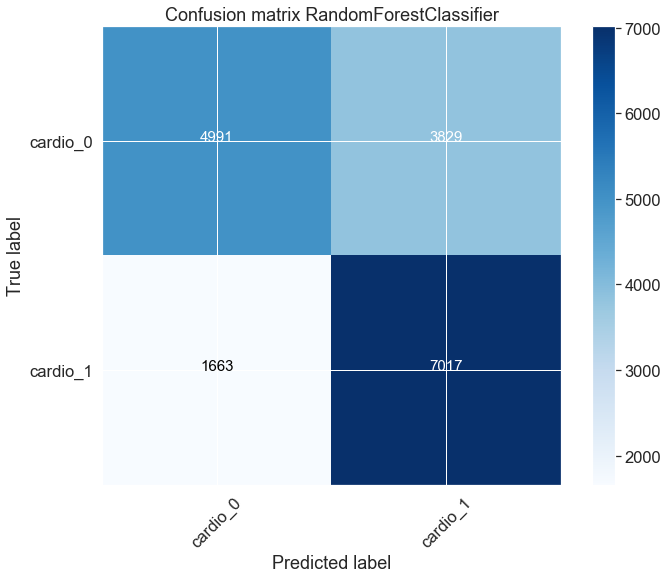

[18:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

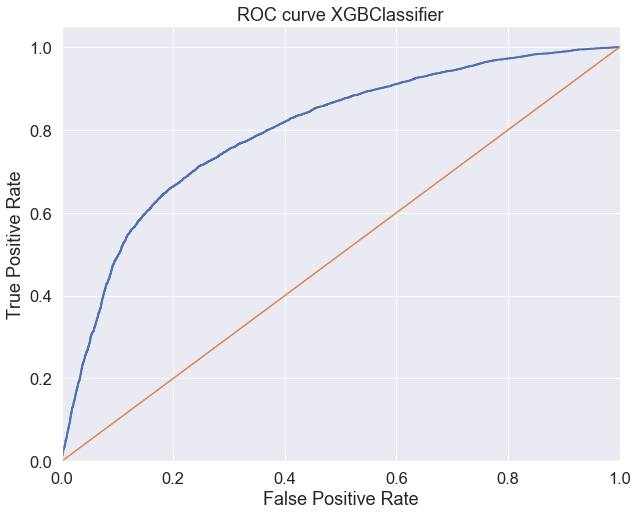

Confusion matrix, without normalization
[[5202 3618]
 [1491 7189]]


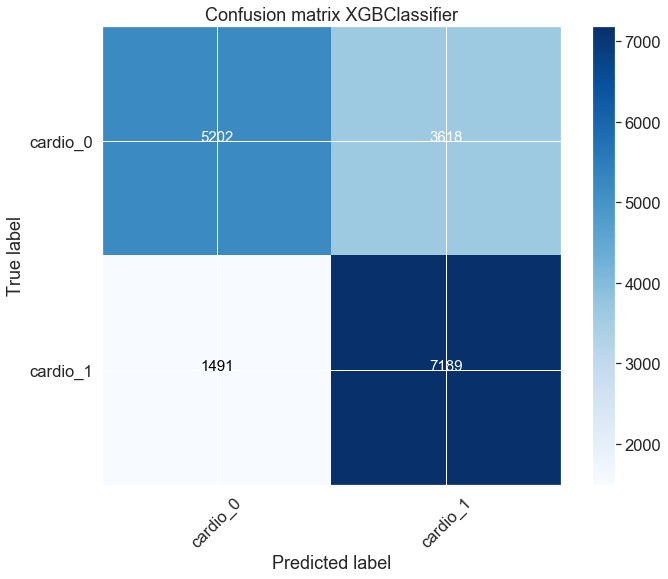

In [17]:
for model in model_list:
    compare_classifiers_metrics = compare_classifiers_metrics.append(decision(model), ignore_index=True)

Выведем сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score в виде таблицы, где строки - модели, а столбцы - метрики

In [18]:
compare_classifiers_metrics

,model,roc_auc,precision,recall,f_score
0,LogisticRegression,0.784035,0.647431,0.837558,0.730323
1,RandomForestClassifier,0.771037,0.642669,0.815553,0.718863
2,XGBClassifier,0.797228,0.665248,0.828341,0.737890


Все модели были запущены с параметрами по умолчанию. Все три показали приблизительно одинаковые результаты, самый лучший результат у XGBoost

Какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Допустим, что модели предсказывают вероятность бинарно (predict_proba = 1 или 0 везде)

In [23]:
y_true5 = np.hstack([np.ones(100), np.zeros(99900)])
y_pred5_1 = np.hstack([np.ones(90), np.zeros(10), np.ones(10), np.zeros(99890)])
y_pred5_2 = np.hstack([np.ones(90), np.zeros(10), np.ones(910), np.zeros(98990)])

In [20]:
model1_TP = 90
model1_FP = 100-90
model1_FN = 100-90
model1_TN = 100000 - model1_TP - model1_FP - model1_FN

model1_TN

99890

In [21]:
model2_TP = 90
model2_FP = 1000-90
model2_FN = 100-90
model2_TN = 100000 - model2_TP - model2_FP - model2_FN

model2_TN

98990

For Модель1 Best Threshold=1.000000, F-Score=0.900, Precision=0.900, Recall=0.900
roc auc = 0.94994994994995


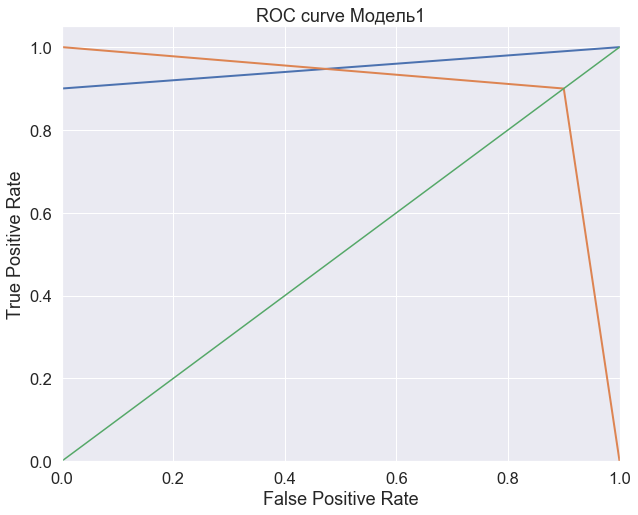

Confusion matrix, without normalization
[[99890    10]
 [   10    90]]


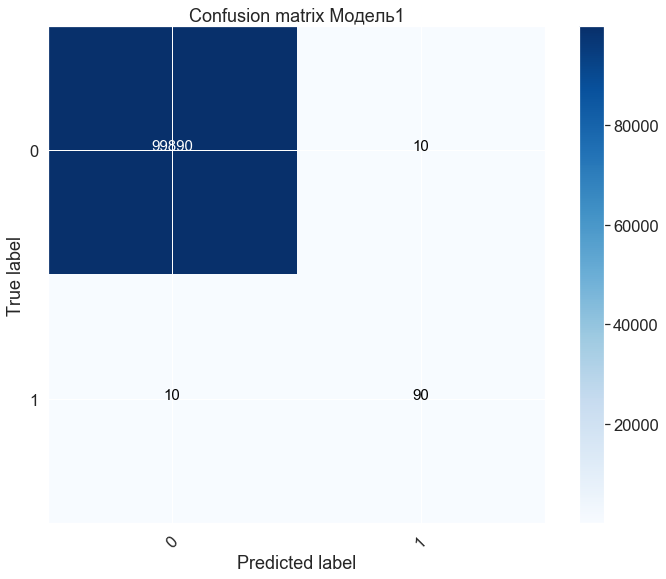

In [28]:
# посчитаем precision/recall/f_score
b=1
precision, recall, thresholds = precision_recall_curve(y_true5, y_pred5_1)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

print('For %s Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % ('Модель1',
                                                                        thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print('roc auc =', roc_auc_score(y_true=y_true5, y_score=y_pred5_1))

#Нарисуем ROC кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_true5, y_pred5_1, pos_label=1)
lw = 2
label_model = ( 'ROC curve ' + 'Модель1' )
plt.plot(fpr, tpr, lw=lw, label=label_model)
plt.plot(precision, recall, lw=lw, label='PR')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(label_model)
plt.savefig("ROC " + label_model + ".png")
plt.show()


# Матрица ошибок; мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_true5, y_pred5_1)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix ' + 'Модель1')
plt.savefig("conf_matrix_" + 'Модель1' + ".png")
plt.show()

For Модель2 Best Threshold=1.000000, F-Score=0.164, Precision=0.090, Recall=0.900
roc auc = 0.9454454454454454


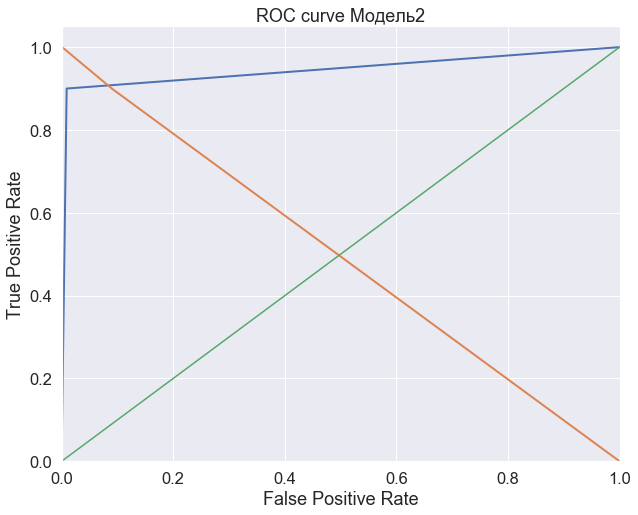

Confusion matrix, without normalization
[[98990   910]
 [   10    90]]


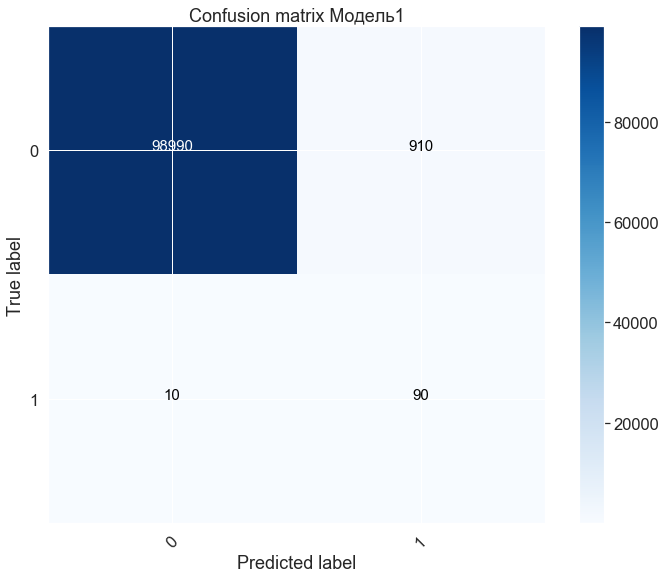

In [29]:
# посчитаем precision/recall/f_score Модель2
b=1
precision, recall, thresholds = precision_recall_curve(y_true5, y_pred5_2)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

print('For %s Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % ('Модель2',
                                                                        thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print('roc auc =', roc_auc_score(y_true=y_true5, y_score=y_pred5_2))


#Нарисуем ROC кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_true5, y_pred5_2, pos_label=1)
lw = 2
label_model = ( 'ROC curve ' + 'Модель2' )
plt.plot(fpr, tpr, lw=lw, label=label_model)
plt.plot(precision, recall, lw=lw, label='PR')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(label_model)
plt.savefig("ROC " + label_model + ".png")
plt.show()


# Матрица ошибок; мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_true5, y_pred5_2)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix ' + 'Модель1')
plt.savefig("conf_matrix_" + 'Модель1' + ".png")
plt.show()

Очевидно, что модель 2 существенно хуже работает.

При этом, метрика ROC AUC на обеих моделях почти одинаковая, разница всего 0,004!. 
Напротив, precision на второй модели очень низкая, что существенно сказывается на PR кривой.

Вывод - при серьезном дисбалансе классов (разреженной выборке) более показательна метрика f1 и PR кривая, нежели ROC AUC